# Data-driven prognostics of Jet Engines
Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)	unit number
	
3)	time, in cycles
4)	operational setting 1
5)	operational setting 2
6)	operational setting 3
7)	sensor measurement  1
8)	sensor measurement  2
...
26)	sensor measurement  26

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
def read_rul_list(file_path:str) -> list:
    '''
    Function transforms txt.file RUL vectors into list of lists
    '''
    l = []
    try:
        with open(file_path, "r") as file:
            for line in file:
                number = int(line.strip())
                l.append(number)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
    return l

# Exploratory Data Analysis

In [3]:
N = 4
all_ruls = []
for i in range(1,N+1):
    l = read_rul_list(f'data/raw/RUL_FD00{i}.txt')
    all_ruls.append(l)

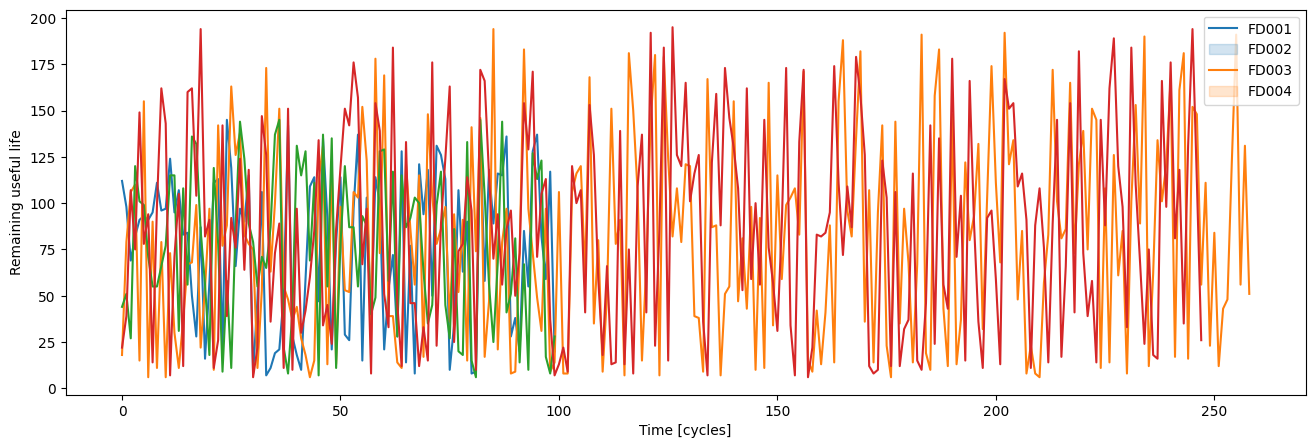

In [4]:
plt.figure(figsize=(16, 5))
titles = []
for i,l in enumerate(all_ruls):
    sns.lineplot(l)
    titles.append(f"FD00{i+1}")
plt.legend(titles)
plt.xlabel('Time [cycles]')
plt.ylabel('Remaining useful life')
plt.show()

In [5]:
def make_dataframe(text_file_path):
    column_names = ['unit_number','time','operational_setting_1','operational_setting_2','operational_setting_3']
    column_names += [f'sensor_measurement_{i}' for i in range(1,24)]
    df = pd.read_csv(text_file_path, sep=" ",header=None,names=column_names)
    # deleting empty columns
    df.dropna(how='all', axis=1, inplace=True) 
    #delete duplicates
    df.drop_duplicates(inplace=True)
    return df

In [6]:
n = 1
text_file_path = f'data/raw/test_FD00{n}.txt'
df =  make_dataframe(text_file_path)


In [7]:
unit=3
operation= 'operational_setting_1'
sensors = ['sensor_measurement_3','sensor_measurement_4','sensor_measurement_5','time']
df1 = df[df['unit_number'] == 3][sensors+[operation]]

In [8]:
data = df1.to_dict('records')

In [9]:
grouped_by = df.groupby(by='unit_number')

In [10]:
result = [entry for entry in data if entry.get('time') == 4][0]
result

{'sensor_measurement_3': 1590.52,
 'sensor_measurement_4': 1401.42,
 'sensor_measurement_5': 14.62,
 'time': 4,
 'operational_setting_1': -0.0011}

In [11]:
max_time = grouped_by['time'].max()
df = df.merge(max_time.to_frame(name='max_time'), left_on='unit_number', right_index=True)
df['RUL'] = df['max_time'] - df['time']

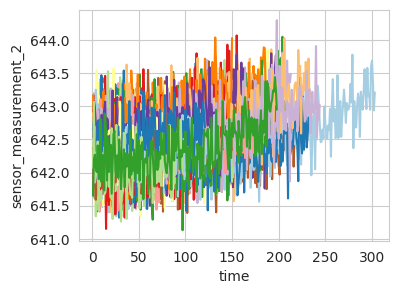

In [12]:
plt.figure(figsize=(4,3))
sns.set_style("whitegrid")
sns.lineplot(df,x ='time',y = 'sensor_measurement_2',hue='unit_number',palette="Paired",legend=False)
plt.show()

In [13]:
def plot_eda(df):
    numeric_columns = [col for col in df.columns if df[col].dtype != 'object' and col not in ['unit_number', 'time', 'max_time', 'RUL','fault_detected']]
    
    num_cols = 4  
    num_rows = (len(numeric_columns) - 1) // num_cols + 1
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
    
    axes = axes.flatten()
    
    # Plot each numeric column
    for i, col in enumerate(numeric_columns):
        sns.lineplot(data=df, x='time', y=col, hue='unit_number', palette='Paired', ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel(col)
        axes[i].legend([])  # Disable legend
    
    plt.tight_layout()
    
    plt.savefig("app/assets/eda.png")


In [14]:
df[df['unit_number'] == 2][['fault_detected','RUL']]

KeyError: "['fault_detected'] not in index"

In [ ]:
#plot_eda(df)

In [15]:
df2 = make_dataframe('data/raw/train_FD001.txt')


In [19]:
def detect_fault(series):
    warning = 0.7
    fault = 0.1
    total_cycles = series.max()  # Maximum cycle for the unit
    threshold_warning = warning * total_cycles
    threshold_fault = fault * total_cycles
    
    def fault_detection(rul):
        if rul > threshold_warning:
            return 0  # Everything is ok
        elif rul > threshold_fault:
            return 1  # Warning
        else:
            return 2  # Fault detected
    
    return series.apply(fault_detection)


In [20]:
df['fault_detected'] = df.groupby('unit_number')['RUL'].transform(detect_fault)

In [23]:
df['fault_detected']

0        0
1        0
2        0
3        0
4        0
        ..
13091    2
13092    2
13093    2
13094    2
13095    2
Name: fault_detected, Length: 13096, dtype: int64